In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.signal import lfilter
import librosa
import librosa.display
from scipy import signal
import IPython.display as ipd

Сгенерируем тестовый сигнал

In [107]:
FS = 16000          # Частота дискретизации
FRAME_LENGTH = 0.025 # Длина фрейма в секундах (25 мс)
FRAME_HOP = 0.010    # Шаг фрейма в секундах (10 мс)
N_FFT = 512         # Размер БПФ
N_MELS = 26         # Количество Mel-фильтров
N_MFCC = 13         # Количество MFCC коэффициентов

In [108]:
def get_source(T, dur, fs):
    Ts = int(T * fs)
    Tp = int(0.4 * Ts)
    Tn = int(0.16 * Ts)
    fp = [3 * (t / Tp) ** 2 - 2 * (t / Tp) ** 3 for t in range(Tp)]
    fn = [1 - ((t - Tp) / Tn) ** 2 for t in range(Tp, Tp + Tn)]
    f0 = [0 for t in range(Tp + Tn, Ts)]
    pulse = fp + fn + f0
    return pulse * int(dur / T)


def filter_source(src, bw, f, fs):
    a2 = np.exp(-2 * np.pi * bw / fs)  # c
    a1 = -2 * np.exp(-np.pi * bw / fs) * np.cos(2 * np.pi * f / fs)  # b
    a0 = 1  # a
    return lfilter([1], [a0, a1, a2], src)


def generate_vowel_like(f0=180, formants=[800, 1200, 2500], duration=0.3, fs=FS):
    """Генерация сигнала, похожего на гласный звук [а]"""
    res = get_source(1 / f0, duration, fs)

    formants = [620,	1220,	2550,	3300,	4500]
    bandwidths = [80, 100, 140, 200, 250]

    for f, bw in zip(formants, bandwidths):
      res = filter_source(res, bw, f, fs)

    return res / np.max(np.abs(res))

In [109]:
speech_signal = generate_vowel_like()
t_audio = np.linspace(0, len(speech_signal)/FS, len(speech_signal))
ipd.Audio(data=speech_signal, rate=FS)

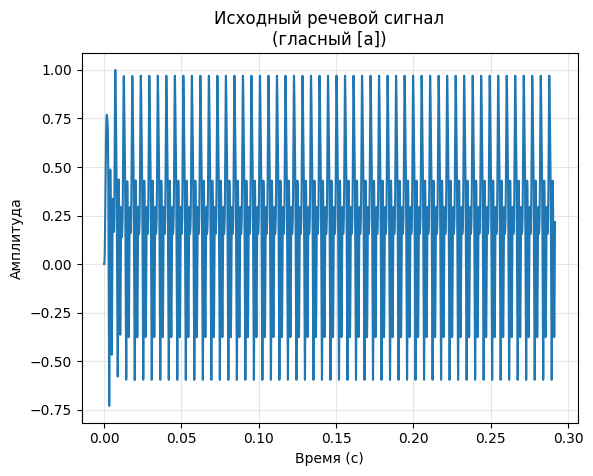

In [110]:
plt.plot(t_audio, speech_signal)
plt.title('Исходный речевой сигнал\n(гласный [а])')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.grid(True, alpha=0.3)

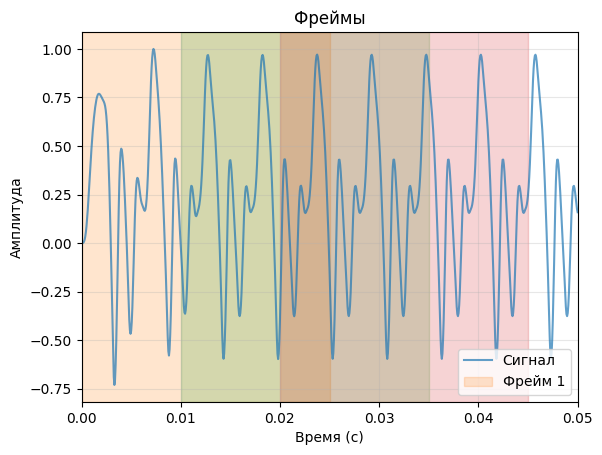

In [111]:
frame_length = int(FRAME_LENGTH * FS)
frame_step = int(FRAME_HOP * FS)
signal_length = len(speech_signal)

# Вычисление количества фреймов
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

# Дополнение сигнала нулями чтобы все фреймы были полными
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(speech_signal, z)

# Создание фреймов
frames = np.zeros((num_frames, frame_length))
for i in range(num_frames):
    start = i * frame_step
    end = start + frame_length
    frames[i] = pad_signal[start:end]

plt.plot(t_audio, speech_signal, alpha=0.7, label='Сигнал')
for i in range(3):
    start_time = i * FRAME_HOP
    end_time = start_time + FRAME_LENGTH
    plt.axvspan(start_time, end_time, alpha=0.2, color=f'C{i+1}', label=f'Фрейм {i+1}' if i == 0 else "")
plt.title('Фреймы')
plt.xlabel('Время (с)')
plt.xlim(0, 0.05)
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True, alpha=0.3)

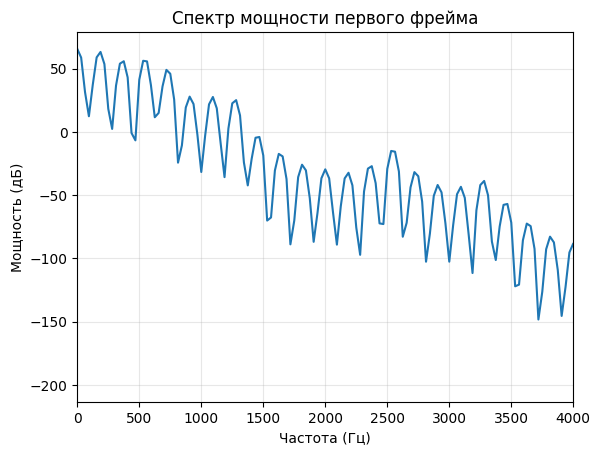

In [112]:
# Применение окна Ханна к фреймам
windows = np.hanning(frame_length)
windowed_frames = frames * windows

# БПФ для первого фрейма
fft_frame = np.fft.rfft(windowed_frames[0], n=N_FFT)
magnitude_spectrum = np.abs(fft_frame)
power_spectrum = magnitude_spectrum ** 2
freqs = np.fft.rfftfreq(N_FFT, 1/FS)

# Визуализация спектра
plt.plot(freqs, 20 * np.log10(power_spectrum + 1e-10))
plt.title('Спектр мощности первого фрейма')
plt.xlabel('Частота (Гц)')
plt.ylabel('Мощность (дБ)')
plt.xlim(0, 4000)
plt.grid(True, alpha=0.3)

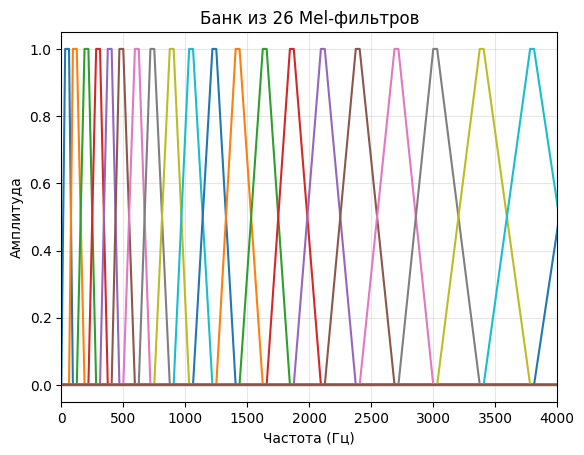

In [113]:
# СОЗДАНИЕ MEL-ФИЛЬТРОВ

# def hz_to_mel(freq):
#     """Преобразование Hz в Mel"""
#     return 1127 * np.log(1 + freq / 700)

# def mel_to_hz(mel):
#     """Преобразование Mel в Hz"""
#     return 700 * (np.exp(mel / 1127.0) - 1)


def hz_to_mel(freq):
    """Преобразование Герц в Mel"""
    return 2595 * np.log10(1 + freq / 700.0)

def mel_to_hz(mel):
    """Преобразование Mel в Герц"""
    return 700 * (10 ** (mel / 2595.0) - 1)


def create_mel_filterbank(n_mels=N_MELS, n_fft=N_FFT, fs=FS):
    """Создание банка Mel-фильтров"""
    # Преобразование граничных частот в Mel
    low_freq_mel = hz_to_mel(0)
    high_freq_mel = hz_to_mel(fs / 2)

    # Равномерные точки в Mel-шкале
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_mels + 2)

    # Обратное преобразование в Герцы
    hz_points = mel_to_hz(mel_points)

    # Частотные бины БПФ
    fft_bins = np.floor((n_fft + 1) * hz_points / fs).astype(int)

    # Создание треугольных фильтров
    filters = np.zeros((n_mels, n_fft // 2 + 1))

    for i in range(n_mels):
        left = fft_bins[i]
        center = fft_bins[i + 1]
        right = fft_bins[i + 2]

        # Восходящий участок
        if center > left:
            filters[i, left:center] = np.linspace(0, 1, center - left)

        # Нисходящий участок
        if right > center:
            filters[i, center:right] = np.linspace(1, 0, right - center)

    return filters, hz_points

# Создание Mel-фильтров
mel_filters, mel_freqs = create_mel_filterbank()

# Визуализация Mel-фильтров
for i in range(N_MELS):
    plt.plot(freqs, mel_filters[i])
plt.title(f'Банк из {N_MELS} Mel-фильтров')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.xlim(0, 4000)
plt.grid(True, alpha=0.3)

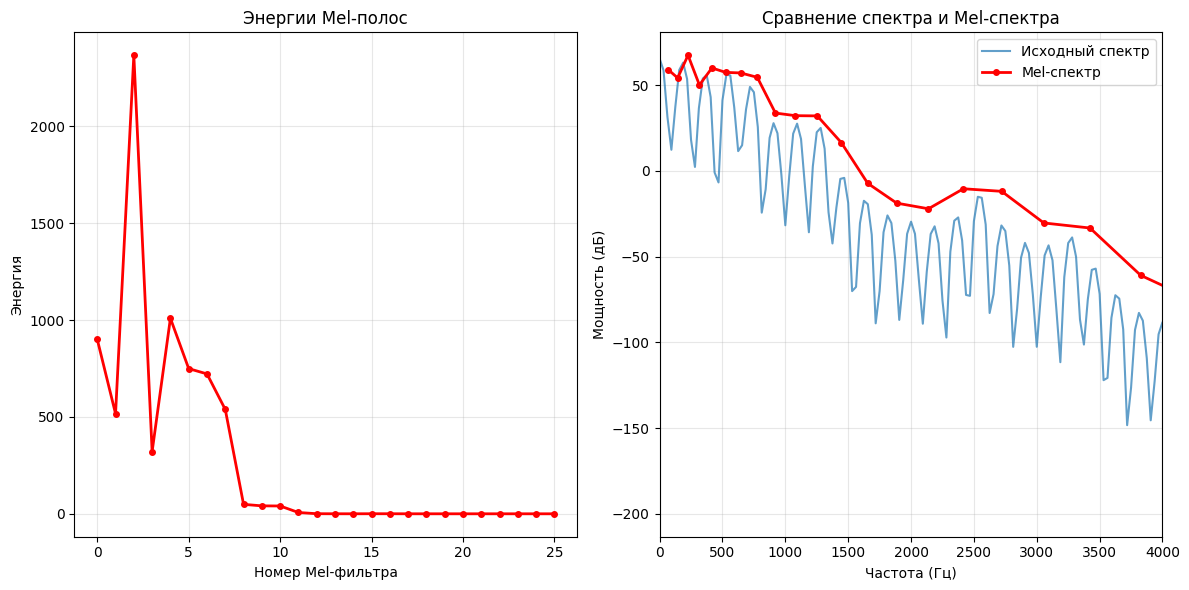

In [114]:
# ПРИМЕНЕНИЕ MEL-ФИЛЬТРОВ

# Применение Mel-фильтров к спектру первого фрейма
mel_energies = np.dot(mel_filters, power_spectrum) # свёртка

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Визуализация Mel-спектра
ax1.plot(range(N_MELS), mel_energies, 'ro-', linewidth=2, markersize=4)
ax1.set_title('Энергии Mel-полос')
ax1.set_xlabel('Номер Mel-фильтра')
ax1.set_ylabel('Энергия')
ax1.grid(True, alpha=0.3)

# Визуализация Mel-спектра на частотной оси
ax2.plot(freqs, 20 * np.log10(power_spectrum + 1e-10), alpha=0.7, label='Исходный спектр')
ax2.plot(mel_freqs[1:-1], 20 * np.log10(mel_energies + 1e-10), 'ro-',
                linewidth=2, markersize=4, label='Mel-спектр')
ax2.set_title('Сравнение спектра и Mel-спектра')
ax2.set_xlabel('Частота (Гц)')
ax2.set_ylabel('Мощность (дБ)')
ax2.set_xlim(0, 4000)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

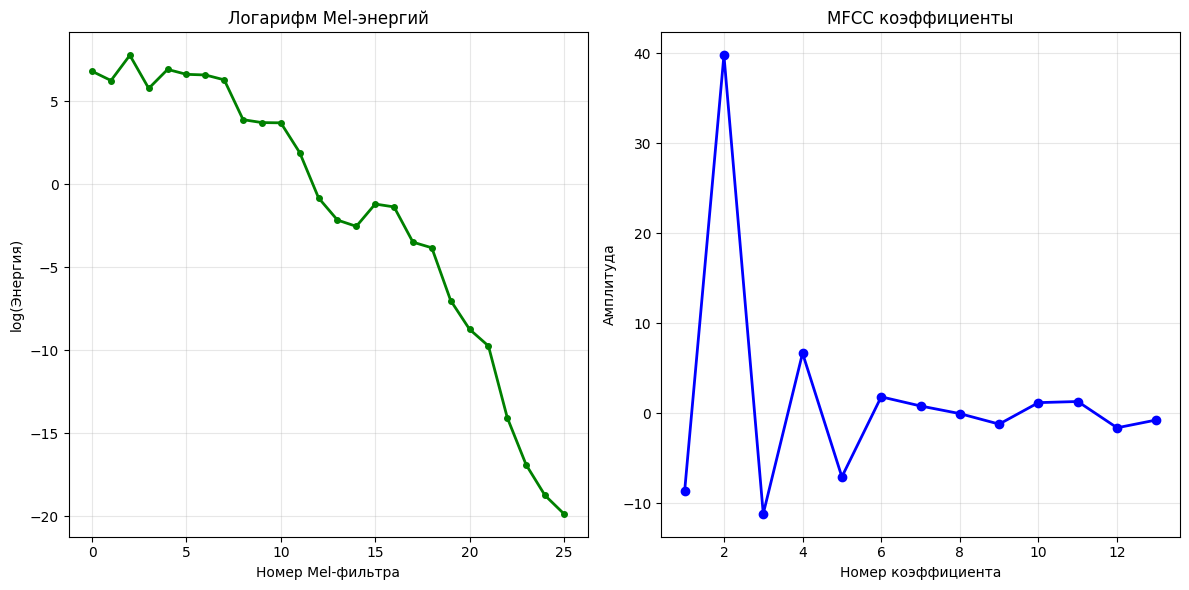

In [115]:
# ЛОГАРИФМИРОВАНИЕ И ДКП

# Логарифмирование
log_mel_energies = np.log(mel_energies + 1e-10)

# Применение ДКП для получения кепстральных коэффициентов
mfcc = dct(log_mel_energies, type=2, axis=0, norm='ortho')[:N_MFCC]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Визуализация логарифмированных энергий
ax1.plot(range(N_MELS), log_mel_energies, 'go-', linewidth=2, markersize=4)
ax1.set_title('Логарифм Mel-энергий')
ax1.set_xlabel('Номер Mel-фильтра')
ax1.set_ylabel('log(Энергия)')
ax1.grid(True, alpha=0.3)

# Визуализация MFCC коэффициентов
ax2.plot(range(1, N_MFCC + 1), mfcc, 'bo-', linewidth=2, markersize=6)
ax2.set_title('MFCC коэффициенты')
ax2.set_xlabel('Номер коэффициента')
ax2.set_ylabel('Амплитуда')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

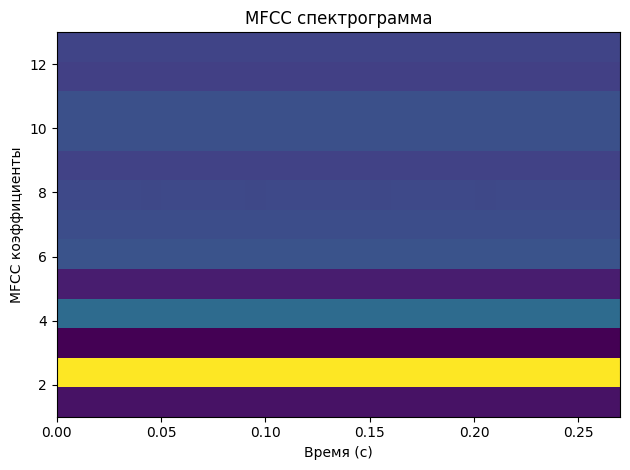

In [116]:
# ОБРАБОТКА ВСЕХ ФРЕЙМОВ

def extract_mfcc_from_frames(frames, n_fft=N_FFT, n_mels=N_MELS, n_mfcc=N_MFCC):
    """Извлечение MFCC для всех фреймов"""
    mfcc_features = []

    for frame in frames:
        # БПФ
        fft_frame = np.fft.rfft(frame, n=n_fft)
        power_spectrum = np.abs(fft_frame) ** 2

        # Mel-фильтрация
        mel_energies = np.dot(mel_filters, power_spectrum)

        # Логарифм + ДКП
        log_mel_energies = np.log(mel_energies + 1e-10)
        mfcc = dct(log_mel_energies, type=2, axis=0, norm='ortho')[:n_mfcc]

        mfcc_features.append(mfcc)

    return np.array(mfcc_features)

# Извлечение MFCC для всех фреймов
mfcc_all_frames = extract_mfcc_from_frames(windowed_frames)

# Визуализация MFCC для всех фреймов (спектрограмма MFCC)
plt.imshow(mfcc_all_frames.T, aspect='auto', origin='lower',
                      extent=[0, len(mfcc_all_frames) * FRAME_HOP, 1, N_MFCC])
plt.title('MFCC спектрограмма')
plt.xlabel('Время (с)')
plt.ylabel('MFCC коэффициенты')

plt.tight_layout()
plt.show()

In [117]:
# Извлечение MFCC с помощью librosa
mfcc_librosa = librosa.feature.mfcc(y=speech_signal, sr=FS, n_mfcc=N_MFCC,
                                   n_fft=N_FFT, hop_length=frame_step,
                                   n_mels=N_MELS, htk=True)
mfcc_librosa

array([[-1.37305779e+02, -1.24995426e+02, -1.25097661e+02,
        -1.25101544e+02, -1.25099493e+02, -1.25091364e+02,
        -1.25087939e+02, -1.25092213e+02, -1.25098041e+02,
        -1.25101968e+02, -1.25095310e+02, -1.25088802e+02,
        -1.25089555e+02, -1.25094643e+02, -1.25101201e+02,
        -1.25099546e+02, -1.25091367e+02, -1.25087939e+02,
        -1.25092213e+02, -1.25098041e+02, -1.25101968e+02,
        -1.25095310e+02, -1.25088802e+02, -1.25089555e+02,
        -1.25094643e+02, -1.25101201e+02, -1.25099546e+02,
        -1.25091367e+02, -9.82841558e+01, -7.09200212e+01],
       [ 1.46173262e+02,  1.47992956e+02,  1.47574694e+02,
         1.47565294e+02,  1.47561234e+02,  1.47569878e+02,
         1.47578685e+02,  1.47579071e+02,  1.47572114e+02,
         1.47561113e+02,  1.47564820e+02,  1.47574825e+02,
         1.47579818e+02,  1.47577101e+02,  1.47565573e+02,
         1.47561181e+02,  1.47569875e+02,  1.47578686e+02,
         1.47579071e+02,  1.47572114e+02,  1.47561113e+